# 1. Packages

In [35]:
import re
import pandas as pd
import numpy as np
from io import StringIO
from PIL import Image
import matplotlib.pyplot as plt
import os, csv

from transformers import CLIPProcessor, CLIPModel
import torch

# 2. Data Ingestion

In [36]:
import math

TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
IMAGE_DIRECTORY = "images"
DATA_BASEPATH = "../dataset"
LABELS = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19']


def append_none_to_caption(df: pd.DataFrame) -> pd.DataFrame:
    """
    Append non-null entries from the 'None' column into the caption column, then drop the 'None' column.
    """
    caption_col = "Caption"
    extra_col = None
    sep = " "

    if extra_col is None:
        if None in df.columns:
            extra_col = None
        elif 'None' in df.columns:
            extra_col = 'None'
        else:
            raise KeyError("Could not find a column named None or 'None' in your DataFrame.")

    # make sure captions are strings
    df[caption_col] = df[caption_col].astype(str)

    # build a Series of the extra text, safely capturing sep in the lambda’s default
    extras = df[extra_col].apply(
        lambda val, sep=sep: (
            '' if pd.isna(val)
            else sep.join(str(item).strip() for item in (val if isinstance(val, (list, tuple)) else [val]))
        )
    )

    # only append where there actually is some extra text
    mask = extras.ne('')
    df.loc[mask, caption_col] = df.loc[mask, caption_col] + sep + extras[mask]

    return df.drop(columns=[extra_col])

def extract_df(filename):
    path = os.path.join(DATA_BASEPATH, filename)
    with open(path, newline="", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile, delimiter=",", quotechar='"', escapechar="\\")
        df = pd.DataFrame(reader)

    return append_none_to_caption(df)

train_data = extract_df(TRAIN_FILENAME)
test_data = extract_df(TEST_FILENAME)


# def encode_label(label, classes_list = ): #encoding the classes into a tensor of shape (11) with 0 and 1s.
#     target = torch.zeros(11)
#     for l in label:
#       idx = classes_list.index(l)
#       target[idx] = 1
#     return target


### 2.1 Creating Datasets

In [38]:
class Sample:
    def __init__(self, id, images, labels, captions):
        """
        Collects and stores relevant information about each data entry.
        Attributes:
            - id, retrieved from the filename
            - image, a PIL image best used for displaying
            - label, a string containing labels. If there is more than one, separated by a space
            - captions, a string containing a description of the image
        """
        self.id = id
        self.image  = images
        self.label  = labels
        self.caption = captions  
    
    def display_data(self):
        plt.imshow(self.image)
        plt.axis('off')      
        plt.title(f"ImageID: {self.id} Label: {self.label}\n{self.caption}", wrap=True)
        plt.show()

    def get_filename(self):
        return f"{self.id}.jpg"
    
    def one_hot_encode(self):
        pass

# 
def retrieve_image(filename):
    """
    Returns an image from a given filename
    """
    return Image.open(f'{DATA_BASEPATH}/{IMAGE_DIRECTORY}/{filename}')

def create_all_samples(dataframe):
    """
    Uses given dataframe to generate all samples which contain an id, image, label and caption.

    Returns a list of samples
    """
    samples = []
    for index, row in dataframe.iterrows():
        filename = row["ImageID"]
        image = retrieve_image(filename)
        label = row["Labels"]
        caption = row["Caption"]
        sample = Sample(filename[:-4], image, label, caption)
        samples.append(sample)
    
    return samples


train_samples = create_all_samples(train_data)
# test_samples = create_all_samples(test_data)


In [2]:
for sample in train_samples:
    if "league" in sample.caption:
        sample.display_data()

NameError: name 'train_samples' is not defined

### 2.3 Preprocessing

In [5]:
def label_to_index(label):
    if label < 1 or label > 19 or label == 12:
        print(f"ERROR: Inavlid label {label}")
    elif label < 12:
        return label - 1
    else:
        return label - 2

def create_dataframe_from_label(dataframe):
    """
    Creates a dataframe that stores all of the captions with the same label in a single string. 
    Attributes:
        - Index
        - Label, 
        - label, a string containing labels. If there is more than one, separated by a space
        - captions, a string containing a description of the image
    """

    data = {
        'Label': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19'],
        'Captions': []
    }
    # print(data)

    data["Captions"] = len(data["Label"]) * [""]
    for index, row in dataframe.iterrows():
        labels = row["Labels"].split()
        caption = row["Caption"]

        for label in labels:
            index = label_to_index(int(label))
            data["Captions"][index] += " " + caption

    print(data)

    return pd.DataFrame(data)


grouped_label_caption = create_dataframe_from_label(train_data)
grouped_label_caption

{'Label': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19'], 'Captions': [' Woman in swim suit holding parasol on sunny day. A couple of men riding horses on top of a green field. They are brave for riding in the jungle on those elephants. A young man riding a skateboard into the air. A man riding a motor bike across a forest. A skate park next to a body of water and green park. Woman cutting pizza with fork and knife sitting next to young girl a man and woman cut into a big cake A piece of cake and coffee are on an outdoor table. People gathered outside in a big field on a cloudy day A stop sign directs pedestrians as a train travels by. a female in military uniform cutting a businessman\'s neck tie Six snowboards are propped in the snow on a rail. A female traveler leaning on a luggage cart. the people are sampling wine at a wine tasting. Beautiful women wearing bikinis frolicking on a sandy beach. A man tossing an orange frisbee on t

,Label,Captions
0,1,Woman in swim suit holding parasol on sunny d...
1,2,People playing tennis on the court on a sunny...
2,3,a black and silver clock tower at an intersec...
3,4,A man riding a motor bike across a forest. Ma...
4,5,A big airplane flying in the big blue sky a s...
5,6,A female traveler leaning on a luggage cart. ...
6,7,A train coming to a stop on the tracks out si...
7,8,a black and silver clock tower at an intersec...
8,9,a couple of boats that are in some water A ma...
9,10,A man holding his hands together while sittin...


In [28]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch


model     = CLIPModel.from_pretrained("tinyclip_local", local_files_only=True)
processor = CLIPProcessor.from_pretrained("tinyclip_local", local_files_only=True)


model.eval()

# Example inference
img = Image.open("images/0.jpg").convert("RGB")
label_names = ["a photo of a man", "a photo of a cat", "a photo of a dog", "a photo of a train"]

inputs = processor(text=label_names, images=img, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

probs = outputs.logits_per_image.softmax(dim=1)

for label, p in zip(label_names, probs[0]):
    print(f"{label:20s} → {p.item():.3f}")


SafetensorError: Error while deserializing header: HeaderTooLarge

In [10]:
from huggingface_hub import snapshot_download
from transformers    import CLIPModel, CLIPProcessor

# this will create "./tinyclip_local" with all the needed files
repo_dir = snapshot_download(
    repo_id="wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M",
    local_dir="tinyclip_local",
    local_dir_use_symlinks=False
)

model     = CLIPModel.from_pretrained(repo_dir, local_files_only=True)
processor = CLIPProcessor.from_pretrained(repo_dir, local_files_only=True)

/opt/miniconda3/envs/A2_COMP4329/lib/python3.9/site-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 9 files: 100%|██████████| 9/9 [00:00<00:00, 8770.62it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [30]:
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-5): 6 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, el

In [ ]:
from PIL import Image
import torch

label_map = {
    1: "a photo containing a person",
    2: "a photo containing a bicycle",
    3: "a photo containing a car",
    4: "a photo containing a motorcycle",
    5: "a photo containing a airplane",
    6: "a photo containing a bus",
    7: "a photo containing a train",
    8: "a photo containing a truck",
    9: "a photo containing a boat",
    10: "a photo containing a traffic light",
    11: "a photo containing a fire hydrant",
    13: "a photo containing a stop sign",
    14: "a photo containing a parking meter",
    15: "a photo containing a bench",
    16: "a photo containing a bird",
    17: "a photo containing a cat",
    18: "a photo containing a dog",
    19: "a photo containing a horse",
}


 
def classify_example_image(sample):
    img = sample.image.convert("RGB")

    # 3) build a batch of prompts in the same order as label_map.keys()
    prompts = [label_map[i] for i in sorted(label_map)]

    # 4) tokenize+preprocess
    inputs = processor(
        text=prompts,      # list[str], one per class
        images=img,        # single PIL image
        return_tensors="pt",
        padding=True
    )

    # 5) forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # 6) CLIPModel returns “logits_per_image” of shape (n_images, n_prompts)
    logits = outputs.logits_per_image  # here: (1, len(prompts))

    # 7) convert to probabilities (softmax over your prompt‐set)
    probs = logits.softmax(dim=1)[0]   # take the first (and only) image

    # 8) pick top‐k or threshold
    topk = torch.topk(probs, k=5)
    for idx, score in zip(topk.indices, topk.values):
        label_id = sorted(label_map)[idx]
        # print(f"Label {label_id} ({label_map[label_id]}):  {score:.3f}")
    
    return sorted(label_map)[topk.indices[0]]


In [ ]:

import torch

# make sure model & processor are already loaded, and on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

caption_label_map = {
    1: "a caption indicating a person exists", 
    2: "a caption containing a bicycle",
    3: "a caption containing a car",
    4: "a caption containing a motorcycle",
    5: "a caption containing a airplane",
    6: "a caption containing a bus",
    7: "a caption containing a train",
    8: "a caption containing a truck",
    9: "a caption containing a boat",
    10: "a caption containing a traffic light",
    11: "a caption containing a fire hydrant",
    13: "a caption containing a stop sign",
    14: "a caption containing a parking meter",
    15: "a caption containing a bench",
    16: "a caption containing a bird",
    17: "a caption containing a cat",
    18: "a caption containing a dog",
    19: "a caption containing a horse",
}

def classify_from_caption(caption, processor, model, label_map, top_k=5):
    # 1) Build your prompts in the sorted label order
    sorted_ids = sorted(label_map)
    prompts    = [label_map[i] for i in sorted_ids]
    
    # 2) Tokenize both the prompts and the single caption
    prompt_inputs = processor(
        text=prompts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    caption_inputs = processor(
        text=[caption],
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # 3) Get the text embeddings
    with torch.no_grad():
        prompt_embeds  = model.get_text_features(**prompt_inputs)   # (n_prompts, D)
        caption_embed  = model.get_text_features(**caption_inputs)  # (1, D)
    
    # 4) L2‐normalize
    prompt_embeds = prompt_embeds / prompt_embeds.norm(dim=1, keepdim=True)
    caption_embed = caption_embed / caption_embed.norm(dim=1, keepdim=True)
    
    # 5) Compute cosine similarities
    sims = (caption_embed @ prompt_embeds.T).squeeze(0)  # (n_prompts,)
    
    # 6) Pick top‐k
    topk = torch.topk(sims, k=top_k)
    top_indices = topk.indices.tolist()
    top_scores  = topk.values.tolist()
    
    # 7) Map back to your label IDs
    top_labels = [ sorted_ids[i] for i in top_indices ]
    # print(top_labels)
    # print(top_scores)
    
    return list(zip(top_labels, top_scores))



In [59]:
def evaluate(samples):
    correct = 0
    total = len(samples)
    for sample in samples:
        # sample = samples[0]
        filename = sample.get_filename()
        image = sample.image
        label = sample.label.split()
        caption = sample.caption

        if len(label) == 1:
            predicted_label = classify_example_image(sample)
            if predicted_label == int(label[0]):
                correct += 1
        else:
            total -= 1
        
    print(f"Accuracy: {correct/total}, Number of samples: {total}")

evaluate(train_samples[0:500])

def evaluate(samples):
    correct = 0
    total = len(samples)
    for sample in samples:
        # sample = samples[0]
        filename = sample.get_filename()
        image = sample.image
        label = sample.label.split()
        caption = sample.caption

        if len(label) == 1: 
            predicted_label = classify_from_caption(caption, processor, model, caption_label_map)
            if predicted_label[0][0] == int(label[0]):
                correct += 1
        else:
            total -= 1
        
    print(f"Accuracy: {correct/total}, Number of samples: {total}")

evaluate(train_samples[0:500])

Accuracy: 0.8348623853211009, Number of samples: 327
Accuracy: 0.5351681957186545, Number of samples: 327


In [ ]:
def evaluate_caption(samples):
    correct = 0
    total = len(samples)
    for sample in samples:
        filename = sample.get_filename()
        image = sample.image
        label = sample.label.split()
        caption = sample.caption

        if len(label) == 1:
            predicted_label = classify_example(sample)
            if predicted_label == int(label[0]):
                correct += 1
        else:
            total -= 1

    print(f"Accuracy: {correct/total}, Number of samples: {total}")

evaluate(train_samples[0:50])

In [45]:
from torch import nn


# 2) Define the fusion head
class FusionClassifier(nn.Module):
    def __init__(self, clip_model, num_labels):
        super().__init__()
        self.clip = clip_model
        dim = clip_model.config.projection_dim  # usually 512
        self.classifier = nn.Sequential(
            nn.Linear(dim*2, dim),
            nn.ReLU(),
            nn.Linear(dim, num_labels)
        )

    def forward(self, pixel_values, input_ids, attention_mask):
        img_emb = self.clip.get_image_features(pixel_values=pixel_values)
        txt_emb = self.clip.get_text_features(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        x = torch.cat([img_emb, txt_emb], dim=1)
        return self.classifier(x)

# 3) Instantiate it (after loading `model` and defining your label_map)
model_cls = FusionClassifier(model, num_labels=len(label_map))


In [61]:
import torch
from PIL import Image

def predict_image_caption(image: str, caption: str, 
                          processor, model_cls, label_map, thresh=0.5):
    """
    Returns a list of label IDs predicted for the given image + caption.
    """
    # 1) Load and preprocess
    img = image.convert("RGB")
    inputs = processor(
        text=[caption],      # wrap in list so batch_size=1
        images=[img],
        return_tensors="pt",
        padding=True
    )

    # Move to same device as model
    device = next(model_cls.parameters()).device
    for k in inputs:
        inputs[k] = inputs[k].to(device)

    # 2) Forward pass
    with torch.no_grad():
        logits = model_cls(
            pixel_values   = inputs['pixel_values'],
            input_ids      = inputs['input_ids'],
            attention_mask = inputs['attention_mask']
        )
    # 3) Multi‐label probabilities
    probs = torch.sigmoid(logits)[0]  # shape = (num_labels,)
    
    # 4) Threshold to get predictions
    pred_idxs = (probs > thresh).nonzero(as_tuple=True)[0].tolist()
    
    # Map back to your original label IDs
    sorted_labels = sorted(label_map)  # e.g. [0,1,2,3,…]
    preds = [ sorted_labels[i] for i in pred_idxs ]
    return preds, probs.cpu().tolist()


# Example usage:
# img_path = samples.
# samples: id, image, label, caption 
for sample in samples:
    sample = samples[7]
    filename = sample.get_filename()
    image = sample.image
    label = sample.label
    caption = sample.caption

    caption = train_data.loc[123, 'Caption']
    predicted_ids, all_probs = predict_image_caption(
        image, caption,
        processor, model_cls, label_map,
        thresh=0.5
    )

    print("Predicted label IDs:", predicted_ids, all_probs)
    print("Corresponding names:", [label_map[i] for i in predicted_ids])
    print(f"Actual Labels: {label}")

    break

Predicted label IDs: [0, 1, 2, 3] [0.547419011592865, 0.520814836025238, 0.5287145376205444, 0.5072341561317444]
Corresponding names: ['a photo of a man', 'a photo of a cat', 'a photo of a dog', 'a photo of a train']
Actual Labels: 1 4


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd

# — assume label_counts is your DataFrame from before —
#    index = label IDs, columns = words, values = counts

# 1) instantiate transformer
tfidf_trans = TfidfTransformer(
    norm=None,        # no L1/L2 normalization; you’ll get raw TF*IDF
    use_idf=True,     # enable the IDF reweighting
    smooth_idf=True,  # adds 1 to DF counts to avoid div-by-zero
    sublinear_tf=False
)

# 2) fit to your counts and transform
tfidf_matrix = tfidf_trans.fit_transform(label_counts.values)
#    shape = (n_labels, vocab_size)

# 3) wrap back into a DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=label_counts.index,
    columns=label_counts.columns
)

# 4) inspect the learned IDF for each term
idf_series = pd.Series(
    tfidf_trans.idf_,
    index=label_counts.columns,
    name='idf'
)

idf_series.sort_values().head()
print(tfidf_df.loc['1'].sort_values(ascending=False).head(10))  # TF–IDF for label “3”

# label_counts: DataFrame, rows=labels, cols=words, vals=raw counts
tfidf = TfidfTransformer(use_idf=True, smooth_idf=True, norm=None)
tfidf_mat = tfidf.fit_transform(label_counts.values)
idf = pd.Series(tfidf.idf_, index=label_counts.columns, name='idf')

# Look at idf for a word:
print(idf['the'])    # likely ≈1 if 'the' is in almost every label
print(idf['train'])  # >1 if 'train' is relatively rare across label-bags



a       41983.0
on       8241.0
of       7906.0
in       6947.0
the      6904.0
man      5534.0
with     4748.0
and      3694.0
is       3437.0
to       2928.0
Name: 1, dtype: float64


In [1]:
find_label = "10"
for sample in train_samples:
    label = sample.label.split(" ")
    # print(label, [find_label]),
    if label == [find_label]:
        sample.display_data()

label_map = {
    1: "a photo containing a person",
    2: "a photo containing a bicycle",
    3: "a photo containing a car",
    4: "a photo containing a motorcycle",
    5: "a photo containing a airplane",
    6: "a photo containing a bus",
    7: "a photo containing a train",
    8: "a photo containing a truck",
    9: "a photo containing a boat",
    10: "a photo containing a traffic light",
    11: "a photo containing a fire hydrant",
    13: "a photo containing a stop sign",
    14: "a photo containing a parking meter",
    15: "a photo containing a bench",
    16: "a photo containing a bird",
    17: "a photo containing a cat",
    18: "a photo containing a dog",
    19: "a photo containing a horse",
}
 

NameError: name 'train_samples' is not defined

In [25]:

def extract_inference(filename):
    path = os.path.join(filename)
    with open(path, newline="", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile, delimiter=",", quotechar='"', escapechar="\\")
        df = pd.DataFrame(reader)

    return df

df = extract_inference("submission.csv")
df

class Sample:
    def __init__(self, id, images, labels, captions):
        """
        Collects and stores relevant information about each data entry.
        Attributes:
            - id, retrieved from the filename
            - image, a PIL image best used for displaying
            - label, a string containing labels. If there is more than one, separated by a space
            - captions, a string containing a description of the image
        """
        self.id = id
        self.image  = images
        self.label  = labels
        self.caption = captions  
    
    def display_data(self):
        plt.imshow(self.image)
        plt.axis('off')      
        plt.title(f"ImageID: {self.id} Label: {self.label}\n{self.caption}", wrap=True)
        plt.show()

    def get_filename(self):
        return f"{self.id}.jpg"
    

def retrieve_image(filename):
    """
    Returns an image from a given filename
    """
    return Image.open(f'{DATA_BASEPATH}/{IMAGE_DIRECTORY}/{filename}')

def create_all_samples(dataframe, is_submission=False):
    """
    Uses given dataframe to generate all samples which contain an id, image, label and caption.

    Returns a list of samples
    """
    samples = []
    caption = None
    for index, row in dataframe.iterrows():
        filename = row["ImageID"]
        image = retrieve_image(filename)
        label = row["Labels"]
        if is_submission == False:
            caption = row["Caption"]
        
        sample = Sample(filename[:-4], image, label, caption)
        samples.append(sample)
    
    return samples


train_samples = create_all_samples(df, is_submission=True)
# test_samples = create_all_samples(test_data)


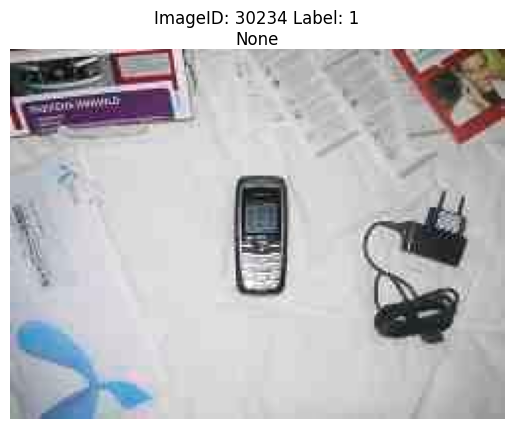

In [34]:
train_samples[234].display_data()